In [1]:
import sys
# Append root path 
sys.path.append("../")
sys.path.append("../lmmnn")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

from model.mixed_effects import *
from utils.fe_models import get_model
from utils.evaluation import *
from utils.utils import *
from data.preprocessing import dataset_preprocessing
from utils.training_functions import *

# from vis.utils.utils import apply_modifications
# # helper function
# def update_layer_activation(model, activation, index=-1):
#     model.layers[index].activation = activation
#     return apply_modifications(model)

from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Reshape, Embedding, Concatenate
from tensorflow.keras.activations import sigmoid

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import roc_auc_score as auroc
from sklearn.metrics import f1_score as f1
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from tensorflow_addons.metrics import F1Score

from scipy import stats
import pickle
import yaml
import time
import gc

RS = 555

SUCCESS: Found GPU: /device:GPU:0


In [2]:
import tempfile
def apply_modifications(model, custom_objects=None):
    """Applies modifications to the model layers to create a new Graph. For example, simply changing
    `model.layers[idx].activation = new activation` does not change the graph. The entire graph needs to be updated
    with modified inbound and outbound tensors because of change in layer building function.

    Args:
        model: The `keras.models.Model` instance.

    Returns:
        The modified model with changes applied. Does not mutate the original `model`.
    """
    # The strategy is to save the modified model and load it back. This is done because setting the activation
    # in a Keras layer doesnt actually change the graph. We have to iterate the entire graph and change the
    # layer inbound and outbound nodes with modified tensors. This is doubly complicated in Keras 2.x since
    # multiple inbound and outbound nodes are allowed with the Graph API.
    model_path = os.path.join(tempfile.gettempdir(), next(tempfile._get_candidate_names()) + '.h5')
    try:
        model.save(model_path)
        return load_model(model_path, custom_objects=custom_objects)
    finally:
        os.remove(model_path)
def update_layer_activation(model, activation, index=-1):
    model.layers[index].activation = activation
    return model

#### Download and save data from Pargent et al. by running "data/download_pargent2022_datasets.py before running this notebook

In [3]:
mode="cv"
hct=10
test_ratio=None
val_ratio=None
folds=5
results = {}
dataset_names = ["churn", "kdd_internet_usage", "Amazon_employee_access", "Click_prediction_small", "adult", "KDDCup09_upselling", "kick", "open_payments", "road-safety-drivers-sex", "porto-seguro"]


loss_use = lambda: tf.keras.losses.BinaryCrossentropy

target= "binary"
batch_size=512
epochs = 200
early_stopping = 5
model_name = "ResNet"
embed_dims_method = "AutoGluon"


results = {}

#######################################

for dataset_name in dataset_names:
    print(f"Start training procedure for {dataset_name}")
    data_path = f"{mode}_RS{RS}_hct{hct}"
    if mode == "cv":
        data_path += f"_{folds}folds"
    elif mode == "train_test":
        data_path += f"_split{1-test_ratio*100}-{test_ratio*100}"
    elif mode == "train_val_test":
        data_path += f"_split{round(100-(test_ratio+val_ratio)*100)}-{round(test_ratio*100)}-{round(val_ratio*100)}"

    # If no data_dict exists, run preprocessing, else load data_dict
    if not os.path.exists(f"../data/prepared/{dataset_name}/"+data_path+"/data_dict.pickle"):
        dataset_preprocessing.process_dataset(dataset_name, target, mode, RS, hct, test_ratio, val_ratio, folds)
    with open(f"../data/prepared/{dataset_name}/{data_path}/data_dict.pickle", 'rb') as handle:
            data_dict = pickle.load(handle)

    z_cols = data_dict["z_cols"]
    results[dataset_name] = {}
    for fold_num in range(folds):
        results[dataset_name][fold_num] = {}

        print(f"Fold no. {fold_num}")
        save_path = f"../results/{dataset_name}/{data_path}/fold_{fold_num}/ResNet_10"
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        
        z_ohe_encoded_train = data_dict[f"z_ohe_encoded_train_{fold_num}"] 
        z_ohe_encoded_val = data_dict[f"z_ohe_encoded_val_{fold_num}"] 
        z_ohe_encoded_test = data_dict[f"z_ohe_encoded_test_{fold_num}"] 

        z_target_encoded_train = data_dict[f"z_target_encoded_train_{fold_num}"] 
        z_target_encoded_val = data_dict[f"z_target_encoded_val_{fold_num}"] 
        z_target_encoded_test = data_dict[f"z_target_encoded_test_{fold_num}"] 
        
        target_encoding_time = data_dict[f"target_encoding_time_{fold_num}"]
        ohe_encoding_time = data_dict[f"ohe_encoding_time_{fold_num}"]
        
        x_cols = data_dict[f"X_train_{fold_num}"].columns
        X_train = data_dict[f"X_train_{fold_num}"]
        Z_train = data_dict[f"Z_train_{fold_num}"]
        y_train = data_dict[f"y_train_{fold_num}"]

        X_val = data_dict[f"X_val_{fold_num}"]
        Z_val = data_dict[f"Z_val_{fold_num}"]
        y_val = data_dict[f"y_val_{fold_num}"]

        X_test = data_dict[f"X_test_{fold_num}"]
        Z_test = data_dict[f"Z_test_{fold_num}"]
        y_test = data_dict[f"y_test_{fold_num}"]
    
        if not os.path.exists(f"{save_path}/results_RS{RS}_{dataset_name}_iter{fold_num}.pickle"):

            tf.random.set_seed(RS+fold_num)
            np.random.seed(RS+fold_num)

            qs = np.max([tf.reduce_max(Z_train, axis=0),tf.reduce_max(Z_val, axis=0),tf.reduce_max(Z_test, axis=0)],axis=0)+1
            
            X_train = tf.convert_to_tensor(X_train)
            Z_train = tf.convert_to_tensor(Z_train,dtype=tf.int32)
            y_train = tf.convert_to_tensor(y_train)

            X_val = tf.convert_to_tensor(X_val)
            Z_val = tf.convert_to_tensor(Z_val,dtype=tf.int32)
            y_val = tf.convert_to_tensor(y_val)

            X_test = tf.convert_to_tensor(X_test)
            Z_test = tf.convert_to_tensor(Z_test,dtype=tf.int32)
            y_test = tf.convert_to_tensor(y_test)

            if target == "categorical":
                n_classes = np.unique(y_train).shape[0]
            elif target=="binary":
                n_classes = 1
            
            y_train = tf.one_hot(tf.cast(y_train,tf.int32),n_classes)
            y_val = tf.one_hot(tf.cast(y_val,tf.int32),n_classes)
            y_test = tf.one_hot(tf.cast(y_test,tf.int32),n_classes)
            
            ##### GMENN #####
            d = X_train.shape[1] # columns
            n = X_train.shape[0] # rows
            num_outputs = n_classes
            perc_numeric = d/(d+Z_train.shape[1])

#             qs = np.max([tf.reduce_max(Z_train, axis=0),tf.reduce_max(Z_val, axis=0),tf.reduce_max(Z_test, axis=0)],axis=0)+1

            set_seed(RS)

            fe_model, optimizer = get_model(model_name=model_name, input_size=X_train.shape[1], 
                                              output_size=num_outputs, 
                                              target=target, 
                                              perc_numeric=perc_numeric, RS=RS)

            initial_stds = np.ones([len(qs),num_outputs]).astype(float).tolist()

            me_model = MixedEffectsNetwork(X_train, Z_train, y_train, fe_model, 
                                           target=target, qs=qs,
                                           initial_stds=initial_stds,
                                          fe_loss_weight=1.,
                                           mode="intercepts",
                                           early_stopping_fe=early_stopping,
                                          )    

            me_model.compile(
                loss_class_me = loss_use()(),
                loss_class_fe = loss_use()(),
            #     metric_class_me = tf.keras.metrics.AUC(multi_label=True, name="auc_me"),
            #     metric_class_fe = tf.keras.metrics.AUC(multi_label=True, name="auc_fe"),
                optimizer=optimizer
            )

            mcmc = MCMCSamplingCallback(num_mcmc_samples=1,
                                        perc_burnin=0.7,
                                        warm_restart=None,
                                        num_burnin_steps=1,
                                        step_size = 0.1#initial_step_size,
                                   )


            print_metric = PrintMetrics(X_train, Z_train, y_train, X_val, Z_val, y_val)

            start = time.time()
            history = me_model.fit([X_train,Z_train], y_train,
                         callbacks=[mcmc,
                                    print_metric,
                                    tf.keras.callbacks.EarlyStopping(monitor="me_auc_val", patience=early_stopping, mode="max")],
                         epochs=epochs,
                         validation_data=[[X_val,Z_val],y_val],
                        batch_size=batch_size)

            end = time.time()
            fit_time_gmenn = round(end-start,2)

            y_train_pred_gmenn, y_train_pred_gmenn_fe = me_model([X_train,Z_train])
            y_val_pred_gmenn, y_val_pred_gmenn_fe = me_model([X_val,Z_val])
            y_test_pred_gmenn, y_test_pred_gmenn_fe = me_model([X_test,Z_test])    

            
            ###### Prepare NN Training ######
            metrics_use = []
            if target =="binary":
                metrics_use.append(tf.keras.metrics.AUC(name="auc"))
                metrics_use.append(tf.keras.metrics.Accuracy(name="accuracy"))
                metrics_use.append(F1Score(num_classes=2, average="micro", name="f1"))
                stop_mode = "max"
                activation_layer = tf.keras.activations.sigmoid
            elif target =="categorical":
                metrics_use.append(tf.keras.metrics.AUC(multi_label=True, name="auc"))
                metrics_use.append(tf.keras.metrics.CategoricalAccuracy(name="accuracy"))
                metrics_use.append(F1Score(num_classes=num_outputs, average="weighted", name="f1"))
                stop_mode = "max"
                activation_layer = tf.keras.activations.softmax
            elif target == "continuous":
                metrics_use.append(RSquare(name="r2"))
                metrics_use.append(tf.keras.metrics.MeanSquaredError(name="mse"))
                stop_mode = "min"            
            
            ##### Ignore #####
            model_nn, optimizer = get_model(model_name=model_name, 
                                            input_size=X_train.shape[1], 
                                            output_size=num_outputs, 
                                            target=target, 
                                            perc_numeric=perc_numeric, RS=RS)
            model_nn.build((n,d))
            update_layer_activation(model=model_nn, activation=activation_layer)

            model_nn.compile(loss=loss_use()(), optimizer=optimizer, metrics = metrics_use)

            callback = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=early_stopping, mode=stop_mode)

            start = time.time()
            history_nn = model_nn.fit(X_train, y_train,
                         validation_data= [X_val, y_val],
                         epochs=epochs, batch_size=batch_size, callbacks=[callback])
            end = time.time()
            fit_time_nn = round(end-start,2)

            y_train_pred_nn = model_nn.predict(X_train ,batch_size=batch_size)
            y_val_pred_nn = model_nn.predict(X_val ,batch_size=batch_size)
            y_test_pred_nn = model_nn.predict(X_test ,batch_size=batch_size)

            if target == "binary":
                eval_res_train_nn = get_metrics(y_train[:,0], y_train_pred_nn, target=target)
                eval_res_val_nn = get_metrics(y_val[:,0], y_val_pred_nn, target=target)
                eval_res_test_nn = get_metrics(y_test[:,0], y_test_pred_nn, target=target)
            elif target == "categorical":
                eval_res_train_nn = get_metrics(y_train, y_train_pred_nn, target=target)
                eval_res_val_nn = get_metrics(y_val, y_val_pred_nn, target=target)
                eval_res_test_nn = get_metrics(y_test, y_test_pred_nn, target=target)

            ##### Target Encoding #####
            print("\n Train Target Encoding Network")
            model_nn_te, optimizer = get_model(model_name=model_name, 
                                            input_size=np.append(X_train ,z_target_encoded_train, axis=1).shape[1], 
                                            output_size=num_outputs, 
                                            target=target, 
                                            perc_numeric=perc_numeric, RS=RS)
            model_nn_te.build((n,np.append(X_train ,z_target_encoded_train, axis=1).shape[1]))
            update_layer_activation(model=model_nn_te, activation=activation_layer)
            model_nn_te.compile(loss=loss_use()(), optimizer=optimizer, metrics = metrics_use)
            callback = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=early_stopping, mode=stop_mode)

            start = time.time()
            history_nn_te = model_nn_te.fit(np.append(X_train ,z_target_encoded_train, axis=1), y_train,
                         validation_data= [np.append(X_val ,z_target_encoded_val, axis=1), y_val],
                         epochs=epochs, batch_size=batch_size, callbacks=[callback])
            end = time.time()
            fit_time_te = round(end-start,2)+target_encoding_time

            y_train_pred_nn_te = model_nn_te.predict(np.append(X_train ,z_target_encoded_train, axis=1) ,batch_size=batch_size)
            y_val_pred_nn_te = model_nn_te.predict(np.append(X_val ,z_target_encoded_val, axis=1) ,batch_size=batch_size)
            y_test_pred_nn_te = model_nn_te.predict(np.append(X_test ,z_target_encoded_test, axis=1) ,batch_size=batch_size)

            if target == "binary":
                eval_res_train_nn_te = get_metrics(y_train[:,0], y_train_pred_nn_te, target=target)
                eval_res_val_nn_te = get_metrics(y_val[:,0], y_val_pred_nn_te, target=target)
                eval_res_test_nn_te = get_metrics(y_test[:,0], y_test_pred_nn_te, target=target)
            elif target == "categorical":
                eval_res_train_nn_te = get_metrics(y_train, y_train_pred_te, target=target)
                eval_res_val_nn_te = get_metrics(y_val, y_val_pred_te, target=target)
                eval_res_test_nn_te = get_metrics(y_test, y_test_pred_te, target=target)

 
            gc.collect()
            ##### OHE #####
            print("\n Train OHE Network")
            model_nn_ohe, optimizer = get_model(model_name=model_name, 
                                            input_size=np.append(X_train ,z_ohe_encoded_train, axis=1).shape[1], 
                                            output_size=num_outputs, 
                                            target=target, 
                                            perc_numeric=perc_numeric, RS=RS)
            model_nn_ohe.build((n,np.append(X_train ,z_ohe_encoded_train, axis=1).shape[1]))
            update_layer_activation(model=model_nn_ohe, activation=activation_layer)
            model_nn_ohe.compile(loss=loss_use()(), optimizer=optimizer, metrics = metrics_use)
            callback = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=early_stopping, mode=stop_mode)

            start = time.time()
            history_nn_ohe = model_nn_ohe.fit(np.append(X_train ,z_ohe_encoded_train, axis=1), y_train,
                         validation_data= [np.append(X_val ,z_ohe_encoded_val, axis=1), y_val],
                         epochs=epochs, batch_size=batch_size, callbacks=[callback])
            end = time.time()
            fit_time_ohe = round(end-start,2)+ohe_encoding_time

            y_train_pred_nn_ohe = model_nn_ohe.predict(np.append(X_train ,z_ohe_encoded_train, axis=1), batch_size=batch_size)
            y_val_pred_nn_ohe = model_nn_ohe.predict(np.append(X_val ,z_ohe_encoded_val, axis=1), batch_size=batch_size)
            y_test_pred_nn_ohe = model_nn_ohe.predict(np.append(X_test ,z_ohe_encoded_test, axis=1), batch_size=batch_size)
            
            if target == "binary":
                eval_res_train_nn_ohe = get_metrics(y_train[:,0], y_train_pred_nn_ohe, target=target)
                eval_res_val_nn_ohe = get_metrics(y_val[:,0], y_val_pred_nn_ohe, target=target)
                eval_res_test_nn_ohe = get_metrics(y_test[:,0], y_test_pred_nn_ohe, target=target)            
            elif target == "categorical":
                eval_res_train_nn_ohe = get_metrics(y_train, y_train_pred_nn_ohe, target=target)
                eval_res_val_nn_ohe = get_metrics(y_val, y_val_pred_nn_ohe, target=target)
                eval_res_test_nn_ohe = get_metrics(y_test, y_test_pred_nn_ohe, target=target)
            gc.collect()   
            ##### Embedding #####
            print("\n Embedding Estimate Network")

            if embed_dims_method=="sqrt":
                embed_dims = [int(np.sqrt(q)) for q in qs]
            elif embed_dims_method=="AutoGluon":
                embed_dims = [int(np.max([100, np.round(1.6*q**0.56)])) for q in qs]
            else:
                embed_dims = [10 for q in qs]

            input_layer = Input(shape=(d,))

            # Define embedding layers
            embed_inputs = []
            embedding_layers = []
            for q_num in range(len(qs)):
                Z_input_layer = Input(shape=(1,))
                embedding_layer = Embedding(qs[q_num], embed_dims[q_num], input_length=1)(Z_input_layer)
                embedding_layer = Reshape(target_shape=(embed_dims[q_num],))(embedding_layer)

                embed_inputs.append(Z_input_layer)
                embedding_layers.append(embedding_layer)

            ### Get model layer dimensions
            min_numeric_embed_dim = 32
            max_numeric_embed_dim = 2056
            max_layer_width = 2056
            # Main dense model
            if target == "continuous":
                default_layer_sizes = [256,
                                       128]  # overall network will have 4 layers. Input layer, 256-unit hidden layer, 128-unit hidden layer, output layer.
            else:
                default_sizes = [256, 128]  # will be scaled adaptively
                # base_size = max(1, min(num_net_outputs, 20)/2.0) # scale layer width based on number of classes
                base_size = max(1, min(num_outputs,
                                       100) / 50)  # TODO: Updated because it improved model quality and made training far faster
                default_layer_sizes = [defaultsize * base_size for defaultsize in default_sizes]
            layer_expansion_factor = 1  # TODO: consider scaling based on num_rows, eg: layer_expansion_factor = 2-np.exp(-max(0,train_dataset.num_examples-10000))
            first_layer_width = int(min(max_layer_width, layer_expansion_factor * default_layer_sizes[0]))

            # numeric embed dim
            vector_dim = 0  # total dimensionality of vector features (I think those should be transformed string features, which we don't have)
            prop_vector_features = perc_numeric  # Fraction of features that are numeric
            numeric_embedding_size = int(min(max_numeric_embed_dim,
                                             max(min_numeric_embed_dim,
                                                 first_layer_width * prop_vector_features * np.log10(vector_dim + 10))))


            numeric_embedding = Dense(numeric_embedding_size, activation="relu")(input_layer)

            concat = Concatenate()([numeric_embedding] + embedding_layers)

            base_model, optimizer = get_model(model_name=model_name, 
                                              input_size=numeric_embedding_size + sum(embed_dims), 
                                              output_size=num_outputs, target=target,
                                              perc_numeric=perc_numeric, RS=RS)

            base_model.build((n, numeric_embedding_size + sum(embed_dims)))
            update_layer_activation(model=base_model, activation=activation_layer)

            layers = base_model(concat)

            model_embed = Model(inputs=[input_layer] + embed_inputs, outputs=layers)


            model_embed.compile(loss=loss_use()(), optimizer=optimizer, metrics = metrics_use)
            callback = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=early_stopping, mode=stop_mode)

            start = time.time()
            history_nn_embed = model_embed.fit([X_train] + [Z_train[: ,q_num] for q_num in range(len(qs))], y_train,
                            validation_data=[[X_val] + [Z_val[: ,q_num] for q_num in range(len(qs))], y_val],
                            epochs=epochs, batch_size=batch_size, callbacks=[callback])
            end = time.time()
            fit_time_embed = round(end-start,2)

            y_train_pred_embed = model_embed.predict([X_train] + [Z_train[: ,q_num] for q_num in range(len(qs))]
                                                     ,batch_size=batch_size)
            y_val_pred_embed = model_embed.predict([X_val] + [Z_val[: ,q_num] for q_num in range(len(qs))]
                                                    ,batch_size=batch_size)
            y_test_pred_embed = model_embed.predict([X_test] + [Z_test[: ,q_num] for q_num in range(len(qs))]
                                                    ,batch_size=batch_size)

            if target == "binary":
                eval_res_train_embed = get_metrics(y_train[:,0], y_train_pred_embed, target=target)
                eval_res_val_embed = get_metrics(y_val[:,0], y_val_pred_embed, target=target)
                eval_res_test_embed = get_metrics(y_test[:,0], y_test_pred_embed, target=target)
            elif target == "categorical":
                eval_res_train_embed = get_metrics(y_train, y_train_pred_embed, target=target)
                eval_res_val_embed = get_metrics(y_val, y_val_pred_embed, target=target)
                eval_res_test_embed = get_metrics(y_test, y_test_pred_embed, target=target)

            eval_res_train_embed, eval_res_test_embed        


            ##### Document Results #####
            
            results[dataset_name][fold_num]["histories"] = {"GMENN": history.history,
                                                       "Ignore": history_nn.history,
                                                       "TE": history_nn_te.history,
#                                                        "GLMM": history_nn_glmm.history,
                                                       "OHE": history_nn_ohe.history,
                                                       "Embedding": history_nn_embed.history,
#                                                        "Point": history_nn_point.history,
#                                                        "LMMNN": [],
#                                                        "ARMED": history_armed.history,
#                                                        "ARMED (no adv.)": history_armed_noadv.history,
                                                      }
            
            results[dataset_name][fold_num]["predictions"] = {"GMENN": [y_train_pred_gmenn, y_val_pred_gmenn, y_test_pred_gmenn],
                                                        "GMENN (FE)": [y_train_pred_gmenn_fe, y_val_pred_gmenn_fe, y_test_pred_gmenn_fe],
                                                        "Ignore": [y_train_pred_nn, y_val_pred_nn, y_test_pred_nn],
                                                        "TE": [y_train_pred_nn_te, y_val_pred_nn_te, y_test_pred_nn_te],
#                                                         "GLMM": [y_train_pred_nn_glmm, y_val_pred_nn_glmm, y_test_pred_nn_glmm],
                                                        "OHE": [y_train_pred_nn_ohe, y_val_pred_nn_ohe, y_test_pred_nn_ohe],
                                                        "Embedding": [y_train_pred_embed, y_val_pred_embed, y_test_pred_embed],
#                                                         "Point": [y_train_pred_point, y_val_pred_point, y_test_pred_point],
#                                                         "Point (FE)": [y_train_pred_point_fe, y_val_pred_point_fe, y_test_pred_point_fe],
#                                                         "LMMNN": [y_train_pred_lmmnn, y_val_pred_lmmnn, y_test_pred_lmmnn],
#                                                         "LMMNN (FE)": [y_train_pred_lmmnn_fe, y_val_pred_lmmnn_fe, y_test_pred_lmmnn_fe],
#                                                         "ARMED": [train_pred_armed, val_pred_armed, test_pred_armed],
#                                                         "ARMED (FE)": [train_pred_armed_fe, val_pred_armed_fe, test_pred_armed_fe],
#                                                         "ARMED (no adv.)": [train_pred_armed_noadv, val_pred_armed_noadv, test_pred_armed_noadv],
#                                                         "ARMED (no adv.) (FE)": [train_pred_armed_noadv_fe, val_pred_armed_noadv_fe, test_pred_armed_noadv_fe],
                                                      }
            
            results[dataset_name][fold_num]["times"] = {"GMENN": fit_time_gmenn,
                                                   "Ignore": fit_time_nn,
                                                   "TE": fit_time_te,
#                                                    "GLMM": fit_time_glmm,
                                                   "OHE": fit_time_ohe,
                                                   "Embedding": fit_time_embed,
#                                                    "Point": fit_time_point,
#                                                    "LMMNN": fit_time_lmmnn,
#                                                    "ARMED": fit_time_armed,
#                                                    "ARMED (no adv.)": fit_time_armed_noadv,
                                                      }
            
            results[dataset_name][fold_num]["other_info"] = {
                "GMENN": {
                    "_stddev_z": np.array([i.numpy() for i in me_model.data_model._stddev_z]),
                    "acceptance_rates": np.array(me_model.acceptance_rates),
                    "random_effects": me_model.mean_samples,
                    "all_samples": me_model.all_samples,
                    "stds": me_model.stds
                },
#                 "LMMNN": {
#                     "_stddev_z": sigmas,
#                     "random_effects": b_hats,
#                 },
#                 "ARMED": {
#                     "_stddev_z": np.std(model_armed.randomeffects.re_int.weights[0].numpy()[:qs[0]]),
#                     "random_effects": model_armed.randomeffects.re_int.weights[0].numpy()[:qs[0]],
#                     "pred_cluster": [train_pred_cluster_armed,val_pred_cluster_armed,test_pred_cluster_armed]
#                 },
#                 "ARMED (no adv.)": {
#                     "_stddev_z": np.std(model_armed_noadv.randomeffects.re_int.weights[0].numpy()[:qs[0]]),
#                     "random_effects": model_armed_noadv.randomeffects.re_int.weights[0].numpy()[:qs[0]],
#                     "pred_cluster": [train_pred_cluster_armed_noadv,val_pred_cluster_armed_noadv,test_pred_cluster_armed_noadv]
#                 }
            }
            
#             del model_lmmnn, model_lmmnn_fe
            
            with open(f"{save_path}//results_RS{RS}_{dataset_name}_iter{fold_num}.pickle", 'wb') as handle:
                pickle.dump(results[dataset_name][fold_num], handle, protocol=pickle.HIGHEST_PROTOCOL)
            
            
            del X_train, X_val, X_test, y_train, y_val, y_test
            del z_target_encoded_train, z_target_encoded_val, z_target_encoded_test
            del z_ohe_encoded_train, z_ohe_encoded_val, z_ohe_encoded_test
#             del z_glmm_encoded_train, z_glmm_encoded_val, z_glmm_encoded_test
            
            gc.collect()
        else:
            print(f"Load results for dataset {dataset_name}, iteration={fold_num}")
            with open(f"{save_path}/results_RS{RS}_{dataset_name}_iter{fold_num}.pickle", 'rb') as handle:
                results[dataset_name][fold_num] = pickle.load(handle)
        


Start training procedure for churn
Fold no. 0
Load results for dataset churn, iteration=0
Fold no. 1
Load results for dataset churn, iteration=1
Fold no. 2
Load results for dataset churn, iteration=2
Fold no. 3
Load results for dataset churn, iteration=3
Fold no. 4
Load results for dataset churn, iteration=4
Start training procedure for kdd_internet_usage
Fold no. 0
Load results for dataset kdd_internet_usage, iteration=0
Fold no. 1
Load results for dataset kdd_internet_usage, iteration=1
Fold no. 2
Load results for dataset kdd_internet_usage, iteration=2
Fold no. 3
Load results for dataset kdd_internet_usage, iteration=3
Fold no. 4
Load results for dataset kdd_internet_usage, iteration=4
Start training procedure for Amazon_employee_access
Fold no. 0
Load results for dataset Amazon_employee_access, iteration=0
Fold no. 1
Load results for dataset Amazon_employee_access, iteration=1
Fold no. 2
Load results for dataset Amazon_employee_access, iteration=2
Fold no. 3
Load results for datase

In [4]:
results.keys()

dict_keys(['churn', 'kdd_internet_usage', 'Amazon_employee_access', 'Click_prediction_small', 'adult', 'KDDCup09_upselling', 'kick', 'open_payments', 'road-safety-drivers-sex', 'porto-seguro'])

## Evaluation

### Performance

In [5]:
models = ["GMENN", "TE", "OHE", "Embedding", "Ignore"]
results_perf = {dataset_name: {num: {model: {}  for model in models} for num in range(folds)} for dataset_name in dataset_names}
for dataset_name in dataset_names:
    try:
        with open(f"../data/prepared/{dataset_name}/{data_path}/data_dict.pickle", 'rb') as handle:
            data_dict = pickle.load(handle)        
    except:
        print(f"dataset {dataset_name} not found") 
    for num in range(folds):
#         print(num)
        n_classes=1
        y_test = tf.one_hot(data_dict[f"y_test_{num}"],n_classes)
        for model in models:
            try:
                y_pred = np.array(results[dataset_name][num]["predictions"][model][2]).ravel()

                results_perf[dataset_name][num][model] = get_metrics(y_test,y_pred,target)
                results_perf[dataset_name][num][model]["Time"] = results[dataset_name][num]["times"][model]
            except:
                print(f"Set nan for {dataset_name}, {num}")
                results_perf[dataset_name][num][model] = {"Accuracy": np.nan,
                                                          "AUROC": np.nan,
                                                          "F1": np.nan,
                                                          "Time": np.nan}


In [6]:
models = ["GMENN", "TE", "OHE", "Embedding", "Ignore"]
metric = "AUROC"

#####
dataset_res_dict = {}
best_models = {}
t_test_results = {}

round_mean_at = 2
round_std_at = 3

for dataset_name in dataset_names:
    dataset_models = list(results_perf[dataset_name][0].keys())
    use_df = pd.DataFrame([pd.DataFrame(results_perf[dataset_name][fold_num]).loc[metric,models] for fold_num in results_perf[dataset_name].keys()],index=results_perf[dataset_name].keys())
    
    df_mean = pd.DataFrame(use_df.mean(axis=0).round(round_mean_at).astype(str) + " (" + use_df.std(axis=0).round(round_std_at).astype(str) + ")").transpose()
    model_dict = {i: df_mean[i].values[0] for i in df_mean.columns}
    dataset_res_dict[dataset_name] = model_dict
    
    best_models[dataset_name] = use_df.columns[use_df.mean(axis=0).argmax()]

    t_test_res = np.array([stats.ttest_rel(use_df[best_models[dataset_name]].values, use_df[model].values)[1] if model in dataset_models else 0 for model in models]).round(3)
    t_test_res[np.isnan(t_test_res)] = 1.
    t_test_results[dataset_name] = t_test_res
    
res_df = pd.DataFrame(dataset_res_dict).transpose()
    
def negative_bold(val):
    i = np.where(val.name==np.array(models))[0][0]
    return ["font-weight: bold"  if t_test_results[dataset_name][i]>=0.05 else "" for dataset_name in val.keys()]
    # Case without transpose:
#     return ["font-weight: bold"  if t_test_results[val.name][i]>=0.05 else "" for i in range(len(val))]

# res_df.style.apply(negative_bold)
res_df

,GMENN,TE,OHE,Embedding,Ignore
churn,0.86 (0.032),0.75 (0.094),0.88 (0.014),0.83 (0.121),0.82 (0.018)
kdd_internet_usage,0.94 (0.006),0.94 (0.005),0.94 (0.006),0.94 (0.007),0.94 (0.005)
Amazon_employee_access,0.84 (0.008),0.69 (0.02),0.83 (0.007),0.82 (0.009),0.5 (0.0)
Click_prediction_small,0.6 (0.015),0.61 (0.016),0.65 (0.007),0.59 (0.025),0.61 (0.009)
adult,0.91 (0.002),0.91 (0.003),0.91 (0.002),0.91 (0.002),0.91 (0.002)
KDDCup09_upselling,0.74 (0.076),0.77 (0.015),0.78 (0.009),0.68 (0.015),0.83 (0.006)
kick,0.76 (0.009),0.76 (0.005),0.76 (0.007),0.75 (0.005),0.76 (0.002)
open_payments,0.94 (0.004),0.9 (0.009),0.93 (0.003),0.93 (0.005),0.5 (0.001)
road-safety-drivers-sex,0.73 (0.004),0.72 (0.001),0.73 (0.003),0.72 (0.002),0.7 (0.004)
porto-seguro,0.62 (0.005),0.63 (0.003),0.63 (0.004),0.63 (0.003),0.63 (0.003)


In [7]:
res_df.apply(negative_bold)

,GMENN,TE,OHE,Embedding,Ignore
churn,font-weight: bold,,font-weight: bold,font-weight: bold,
kdd_internet_usage,,font-weight: bold,font-weight: bold,,font-weight: bold
Amazon_employee_access,font-weight: bold,,font-weight: bold,,
Click_prediction_small,,,font-weight: bold,,
adult,,font-weight: bold,,font-weight: bold,
KDDCup09_upselling,font-weight: bold,,,,font-weight: bold
kick,,font-weight: bold,font-weight: bold,,font-weight: bold
open_payments,font-weight: bold,,,,
road-safety-drivers-sex,font-weight: bold,,font-weight: bold,,
porto-seguro,,font-weight: bold,font-weight: bold,,font-weight: bold


In [8]:
res_df.columns = ["MC-GMENN", "TE", "OHE", "Embedding", "Ignore"]
print(res_df.to_latex(index=True))
res_df

\begin{tabular}{llllll}
\toprule
{} &      MC-GMENN &            TE &           OHE &     Embedding &        Ignore \\
\midrule
churn                   &  0.86 (0.032) &  0.75 (0.094) &  0.88 (0.014) &  0.83 (0.121) &  0.82 (0.018) \\
kdd\_internet\_usage      &  0.94 (0.006) &  0.94 (0.005) &  0.94 (0.006) &  0.94 (0.007) &  0.94 (0.005) \\
Amazon\_employee\_access  &  0.84 (0.008) &   0.69 (0.02) &  0.83 (0.007) &  0.82 (0.009) &     0.5 (0.0) \\
Click\_prediction\_small  &   0.6 (0.015) &  0.61 (0.016) &  0.65 (0.007) &  0.59 (0.025) &  0.61 (0.009) \\
adult                   &  0.91 (0.002) &  0.91 (0.003) &  0.91 (0.002) &  0.91 (0.002) &  0.91 (0.002) \\
KDDCup09\_upselling      &  0.74 (0.076) &  0.77 (0.015) &  0.78 (0.009) &  0.68 (0.015) &  0.83 (0.006) \\
kick                    &  0.76 (0.009) &  0.76 (0.005) &  0.76 (0.007) &  0.75 (0.005) &  0.76 (0.002) \\
open\_payments           &  0.94 (0.004) &   0.9 (0.009) &  0.93 (0.003) &  0.93 (0.005) &   0.5 (0.001) \\
road-saf

,MC-GMENN,TE,OHE,Embedding,Ignore
churn,0.86 (0.032),0.75 (0.094),0.88 (0.014),0.83 (0.121),0.82 (0.018)
kdd_internet_usage,0.94 (0.006),0.94 (0.005),0.94 (0.006),0.94 (0.007),0.94 (0.005)
Amazon_employee_access,0.84 (0.008),0.69 (0.02),0.83 (0.007),0.82 (0.009),0.5 (0.0)
Click_prediction_small,0.6 (0.015),0.61 (0.016),0.65 (0.007),0.59 (0.025),0.61 (0.009)
adult,0.91 (0.002),0.91 (0.003),0.91 (0.002),0.91 (0.002),0.91 (0.002)
KDDCup09_upselling,0.74 (0.076),0.77 (0.015),0.78 (0.009),0.68 (0.015),0.83 (0.006)
kick,0.76 (0.009),0.76 (0.005),0.76 (0.007),0.75 (0.005),0.76 (0.002)
open_payments,0.94 (0.004),0.9 (0.009),0.93 (0.003),0.93 (0.005),0.5 (0.001)
road-safety-drivers-sex,0.73 (0.004),0.72 (0.001),0.73 (0.003),0.72 (0.002),0.7 (0.004)
porto-seguro,0.62 (0.005),0.63 (0.003),0.63 (0.004),0.63 (0.003),0.63 (0.003)


In [9]:
dataset_df = {}
for dataset_name in dataset_names:
    dataset_models = list(results_perf[dataset_name][0].keys())
    use_df = pd.DataFrame([pd.DataFrame(results_perf[dataset_name][fold_num]).loc[metric,models] for fold_num in results_perf[dataset_name].keys()],index=results_perf[dataset_name].keys())
    dataset_df[dataset_name] = use_df
    
mean_df = pd.DataFrame({dataset_name: dataset_df[dataset_name].mean(axis=0) for dataset_name in dataset_names})

# Mean reciprocal rank
print(np.mean((1/mean_df.rank(axis=0,ascending=False)),axis=1).round(2))

# Mean rank
print(np.mean((mean_df.rank(axis=0,ascending=False)),axis=1).round(2))

# Average distance to best
print(mean_df.apply(lambda x: np.abs(x-np.max(x)),axis=0).mean(axis=1).round(4)-mean_df.apply(lambda x: np.abs(x-np.max(x)),axis=0).mean(axis=1).round(4).min())

# Average distance to best
print((mean_df.mean(axis=1)-mean_df.mean(axis=1).max()).round(4))
print(mean_df.apply(lambda x: (100*(np.max(x)-x)/np.max(x)),axis=0).mean(axis=1).round(4))

mean_df

GMENN        0.44
TE           0.40
OHE          0.70
Embedding    0.30
Ignore       0.44
dtype: float64
GMENN        3.2
TE           3.0
OHE          1.8
Embedding    3.7
Ignore       3.3
dtype: float64
GMENN        0.0104
TE           0.0342
OHE          0.0000
Embedding    0.0237
Ignore       0.0842
dtype: float64
GMENN       -0.0103
TE          -0.0342
OHE          0.0000
Embedding   -0.0237
Ignore      -0.0842
dtype: float64
GMENN         2.3431
TE            5.0345
OHE           0.8883
Embedding     3.9474
Ignore       10.5655
dtype: float64


,churn,kdd_internet_usage,Amazon_employee_access,Click_prediction_small,adult,KDDCup09_upselling,kick,open_payments,road-safety-drivers-sex,porto-seguro
GMENN,0.864327,0.937130,0.836038,0.596260,0.911625,0.744563,0.755644,0.937730,0.730295,0.623820
TE,0.751508,0.944020,0.694057,0.612708,0.913299,0.772846,0.758597,0.904253,0.718777,0.628593
OHE,0.882376,0.942187,0.828456,0.650334,0.912065,0.776588,0.760244,0.925617,0.731877,0.630880
Embedding,0.826534,0.941520,0.816079,0.592569,0.912797,0.684321,0.754347,0.931240,0.717880,0.626521
Ignore,0.815517,0.944325,0.500000,0.610449,0.908515,0.829003,0.759375,0.504872,0.697444,0.629316


#### With multiclass results from other notebook

In [10]:
res_multi = pd.DataFrame([[0.90538176, 0.86717249, 0.89285583, 0.77507623, 0.80521861,
        0.6676946 ],
       [0.89694711, 0.77180405, 0.80679814, 0.62629576, 0.67216583,
        0.61935787],
       [0.90925224, 0.82610089, 0.90502755, 0.77694336, 0.81552722,
        0.67823328],
       [0.9023829 , 0.85652943, 0.9096573 , 0.77905144, 0.80283276,
        0.67456942],
       [0.91109796, 0.78601487, 0.79732988, 0.68943129, 0.74127877,
        0.64388348]],index=models)

In [11]:
df_mean_allreal = pd.concat([mean_df,res_multi],axis=1)

# Mean reciprocal rank
print(np.mean((1/df_mean_allreal.rank(axis=0,ascending=False)),axis=1).round(2))

# Mean rank
print(np.mean((df_mean_allreal.rank(axis=0,ascending=False)),axis=1).round(2))

# Average distance to best
print(df_mean_allreal.apply(lambda x: np.abs(x-np.max(x)),axis=0).mean(axis=1).round(4))
print(df_mean_allreal.apply(lambda x: (100*(np.max(x)-x)/np.max(x)),axis=0).mean(axis=1).round(4))

df_mean_allreal

GMENN        0.45
TE           0.33
OHE          0.68
Embedding    0.41
Ignore       0.41
dtype: float64
GMENN        2.94
TE           3.69
OHE          1.81
Embedding    3.12
Ignore       3.44
dtype: float64
GMENN        0.0141
TE           0.0616
OHE          0.0078
Embedding    0.0218
Ignore       0.0818
dtype: float64
GMENN        1.8271
TE           7.5044
OHE          0.9126
Embedding    2.7346
Ignore       9.5647
dtype: float64


,churn,kdd_internet_usage,Amazon_employee_access,Click_prediction_small,adult,KDDCup09_upselling,kick,open_payments,road-safety-drivers-sex,porto-seguro,0,1,2,3,4,5
GMENN,0.864327,0.937130,0.836038,0.596260,0.911625,0.744563,0.755644,0.937730,0.730295,0.623820,0.905382,0.867172,0.892856,0.775076,0.805219,0.667695
TE,0.751508,0.944020,0.694057,0.612708,0.913299,0.772846,0.758597,0.904253,0.718777,0.628593,0.896947,0.771804,0.806798,0.626296,0.672166,0.619358
OHE,0.882376,0.942187,0.828456,0.650334,0.912065,0.776588,0.760244,0.925617,0.731877,0.630880,0.909252,0.826101,0.905028,0.776943,0.815527,0.678233
Embedding,0.826534,0.941520,0.816079,0.592569,0.912797,0.684321,0.754347,0.931240,0.717880,0.626521,0.902383,0.856529,0.909657,0.779051,0.802833,0.674569
Ignore,0.815517,0.944325,0.500000,0.610449,0.908515,0.829003,0.759375,0.504872,0.697444,0.629316,0.911098,0.786015,0.797330,0.689431,0.741279,0.643883


In [12]:
rank_avgdist = pd.DataFrame([np.mean((df_mean_allreal.rank(axis=0,ascending=False)),axis=1).round(2),
              df_mean_allreal.apply(lambda x: np.abs(x-np.max(x)),axis=0).mean(axis=1).round(3)])
print(rank_avgdist.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  GMENN &     TE &    OHE &  Embedding &  Ignore \\
\midrule
0 &  2.940 &  3.690 &  1.810 &      3.120 &   3.440 \\
1 &  0.014 &  0.062 &  0.008 &      0.022 &   0.082 \\
\bottomrule
\end{tabular}



### Time

In [13]:
models = ["GMENN", "TE", "OHE", "Embedding", "Ignore"]
metric = "Time"

#####
dataset_res_dict = {}
best_models = {}
t_test_results = {}

round_mean_at = 2
round_std_at = 3

for dataset_name in dataset_names:
    dataset_models = list(results_perf[dataset_name][0].keys())
    use_df = pd.DataFrame([pd.DataFrame(results_perf[dataset_name][fold_num]).loc[metric,models] for fold_num in results_perf[dataset_name].keys()],index=results_perf[dataset_name].keys())/60
    
    df_mean = pd.DataFrame(use_df.mean(axis=0).round(round_mean_at).astype(str) + " (" + use_df.std(axis=0).round(round_std_at).astype(str) + ")").transpose()
    model_dict = {i: df_mean[i].values[0] for i in df_mean.columns}
    dataset_res_dict[dataset_name] = model_dict
    
    best_models[dataset_name] = use_df.columns[use_df.mean(axis=0).argmin()]

    t_test_res = np.array([stats.ttest_rel(use_df[best_models[dataset_name]].values, use_df[model].values)[1] if model in dataset_models else 0 for model in models]).round(3)
    t_test_res[np.isnan(t_test_res)] = 1.
    t_test_results[dataset_name] = t_test_res
    
res_df = pd.DataFrame(dataset_res_dict).transpose()
    
def negative_bold(val):
    i = np.where(val.name==np.array(models))[0][0]
    return ["font-weight: bold"  if t_test_results[dataset_name][i]>=0.05 else "" for dataset_name in val.keys()]
    # Case without transpose:
#     return ["font-weight: bold"  if t_test_results[val.name][i]>=0.05 else "" for i in range(len(val))]

# res_df.style.apply(negative_bold)
res_df

,GMENN,TE,OHE,Embedding,Ignore
churn,3.34 (1.183),2.33 (2.006),4.01 (0.342),1.6 (0.738),3.88 (0.454)
kdd_internet_usage,8.31 (6.088),2.65 (0.572),1.81 (0.28),1.18 (0.092),2.94 (0.774)
Amazon_employee_access,1.53 (0.483),0.64 (0.252),1.65 (0.167),2.26 (0.236),0.42 (0.016)
Click_prediction_small,1.18 (0.299),0.93 (0.067),3.32 (0.854),1.62 (0.067),0.98 (0.136)
adult,4.84 (0.853),5.83 (2.268),4.76 (1.638),2.22 (0.695),5.25 (2.478)
KDDCup09_upselling,3.08 (0.908),1.05 (0.049),0.79 (0.058),2.11 (0.243),2.15 (0.318)
kick,1.99 (0.166),2.22 (0.811),1.85 (0.106),1.23 (0.141),2.82 (0.466)
open_payments,0.97 (0.031),1.26 (0.577),0.93 (0.082),1.13 (0.088),0.38 (0.012)
road-safety-drivers-sex,2.45 (0.587),1.08 (0.049),2.69 (0.816),1.18 (0.063),2.07 (0.465)
porto-seguro,4.79 (0.854),7.59 (2.728),5.97 (1.779),3.51 (0.666),7.2 (2.039)


In [14]:
t_test_results

{'churn': array([0.077, 0.42 , 0.   , 1.   , 0.008]),
 'kdd_internet_usage': array([0.059, 0.004, 0.004, 1.   , 0.005]),
 'Amazon_employee_access': array([0.007, 0.116, 0.   , 0.   , 1.   ]),
 'Click_prediction_small': array([0.135, 1.   , 0.003, 0.   , 0.584]),
 'adult': array([0.   , 0.012, 0.012, 1.   , 0.024]),
 'KDDCup09_upselling': array([0.004, 0.001, 1.   , 0.   , 0.001]),
 'kick': array([0.002, 0.049, 0.001, 1.   , 0.002]),
 'open_payments': array([0.   , 0.027, 0.   , 0.   , 1.   ]),
 'road-safety-drivers-sex': array([0.006, 1.   , 0.013, 0.083, 0.008]),
 'porto-seguro': array([0.003, 0.014, 0.014, 1.   , 0.01 ])}

In [15]:
res_df.apply(negative_bold)

,GMENN,TE,OHE,Embedding,Ignore
churn,font-weight: bold,font-weight: bold,,font-weight: bold,
kdd_internet_usage,font-weight: bold,,,font-weight: bold,
Amazon_employee_access,,font-weight: bold,,,font-weight: bold
Click_prediction_small,font-weight: bold,font-weight: bold,,,font-weight: bold
adult,,,,font-weight: bold,
KDDCup09_upselling,,,font-weight: bold,,
kick,,,,font-weight: bold,
open_payments,,,,,font-weight: bold
road-safety-drivers-sex,,font-weight: bold,,font-weight: bold,
porto-seguro,,,,font-weight: bold,


In [16]:
res_df.columns = ["MC-GMENN", "TE", "OHE", "Embedding", "Ignore"]
print(res_df.to_latex(index=True))
res_df

\begin{tabular}{llllll}
\toprule
{} &      MC-GMENN &            TE &           OHE &     Embedding &        Ignore \\
\midrule
churn                   &  3.34 (1.183) &  2.33 (2.006) &  4.01 (0.342) &   1.6 (0.738) &  3.88 (0.454) \\
kdd\_internet\_usage      &  8.31 (6.088) &  2.65 (0.572) &   1.81 (0.28) &  1.18 (0.092) &  2.94 (0.774) \\
Amazon\_employee\_access  &  1.53 (0.483) &  0.64 (0.252) &  1.65 (0.167) &  2.26 (0.236) &  0.42 (0.016) \\
Click\_prediction\_small  &  1.18 (0.299) &  0.93 (0.067) &  3.32 (0.854) &  1.62 (0.067) &  0.98 (0.136) \\
adult                   &  4.84 (0.853) &  5.83 (2.268) &  4.76 (1.638) &  2.22 (0.695) &  5.25 (2.478) \\
KDDCup09\_upselling      &  3.08 (0.908) &  1.05 (0.049) &  0.79 (0.058) &  2.11 (0.243) &  2.15 (0.318) \\
kick                    &  1.99 (0.166) &  2.22 (0.811) &  1.85 (0.106) &  1.23 (0.141) &  2.82 (0.466) \\
open\_payments           &  0.97 (0.031) &  1.26 (0.577) &  0.93 (0.082) &  1.13 (0.088) &  0.38 (0.012) \\
road-saf

,MC-GMENN,TE,OHE,Embedding,Ignore
churn,3.34 (1.183),2.33 (2.006),4.01 (0.342),1.6 (0.738),3.88 (0.454)
kdd_internet_usage,8.31 (6.088),2.65 (0.572),1.81 (0.28),1.18 (0.092),2.94 (0.774)
Amazon_employee_access,1.53 (0.483),0.64 (0.252),1.65 (0.167),2.26 (0.236),0.42 (0.016)
Click_prediction_small,1.18 (0.299),0.93 (0.067),3.32 (0.854),1.62 (0.067),0.98 (0.136)
adult,4.84 (0.853),5.83 (2.268),4.76 (1.638),2.22 (0.695),5.25 (2.478)
KDDCup09_upselling,3.08 (0.908),1.05 (0.049),0.79 (0.058),2.11 (0.243),2.15 (0.318)
kick,1.99 (0.166),2.22 (0.811),1.85 (0.106),1.23 (0.141),2.82 (0.466)
open_payments,0.97 (0.031),1.26 (0.577),0.93 (0.082),1.13 (0.088),0.38 (0.012)
road-safety-drivers-sex,2.45 (0.587),1.08 (0.049),2.69 (0.816),1.18 (0.063),2.07 (0.465)
porto-seguro,4.79 (0.854),7.59 (2.728),5.97 (1.779),3.51 (0.666),7.2 (2.039)


In [17]:
dataset_df = {}
for dataset_name in dataset_names:
    dataset_models = list(results_perf[dataset_name][0].keys())
    use_df = pd.DataFrame([pd.DataFrame(results_perf[dataset_name][fold_num]).loc[metric,models] for fold_num in results_perf[dataset_name].keys()],index=results_perf[dataset_name].keys())/60
    dataset_df[dataset_name] = use_df
    
mean_df = pd.DataFrame({dataset_name: dataset_df[dataset_name].mean(axis=0) for dataset_name in dataset_names})#*-1

# Mean reciprocal rank
print(np.mean((1/(mean_df*-1).rank(axis=0,ascending=False)),axis=1).round(2))

# Mean rank
print(np.mean(((mean_df*-1).rank(axis=0,ascending=False)),axis=1).round(2))

# Average distance to best
# In %
print(mean_df.apply(lambda x: (-100*(np.min(x)-x)/np.min(x)),axis=0).mean(axis=1).round(4))

# absolute
print(mean_df.apply(lambda x: np.abs(x-np.min(x)),axis=0).mean(axis=1).round(4))

mean_df

GMENN        0.32
TE           0.47
OHE          0.42
Embedding    0.65
Ignore       0.43
dtype: float64
GMENN        3.4
TE           3.0
OHE          3.1
Embedding    2.3
Ignore       3.2
dtype: float64
GMENN        179.8497
TE            84.9699
OHE          128.4916
Embedding     88.9107
Ignore        93.4816
dtype: float64
GMENN        1.9156
TE           1.2261
OHE          1.4441
Embedding    0.4692
Ignore       1.4766
dtype: float64


,churn,kdd_internet_usage,Amazon_employee_access,Click_prediction_small,adult,KDDCup09_upselling,kick,open_payments,road-safety-drivers-sex,porto-seguro
GMENN,3.344000,8.311300,1.529133,1.182400,4.838600,3.076767,1.991633,0.967967,2.453800,4.790567
TE,2.327754,2.652475,0.635147,0.934854,5.828863,1.054046,2.224416,1.262491,1.084393,7.587242
OHE,4.007163,1.814417,1.654638,3.315356,4.762993,0.785471,1.845679,0.933375,2.685603,5.967372
Embedding,1.598833,1.176600,2.255267,1.621300,2.219900,2.110567,1.225700,1.130600,1.175633,3.507767
Ignore,3.876067,2.944533,0.416400,0.979533,5.253800,2.152833,2.820700,0.380733,2.074233,7.197500


In [18]:
print(pd.DataFrame(np.mean((1/(-1*mean_df).rank(axis=0,ascending=False)),axis=1).round(2)).transpose().to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  GMENN &    TE &   OHE &  Embedding &  Ignore \\
\midrule
0 &   0.32 &  0.47 &  0.42 &       0.65 &    0.43 \\
\bottomrule
\end{tabular}



In [19]:
print(pd.DataFrame(mean_df.apply(lambda x: np.abs(x-np.min(x)),axis=0).mean(axis=1).round(2)).transpose().to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  GMENN &    TE &   OHE &  Embedding &  Ignore \\
\midrule
0 &   1.92 &  1.23 &  1.44 &       0.47 &    1.48 \\
\bottomrule
\end{tabular}



### Variance components

In [20]:
tf.random.set_seed(RS)
stds_all = {}
re_all = {}
sig_df_dict = {}
z_col_dict = {}

for dataset_name in dataset_names:    
    stds_all[dataset_name] = {}
    re_all[dataset_name] = {}

    print(f"Load results for {dataset_name}")
    data_path = f"{mode}_RS{RS}_hct{hct}"
    if mode == "cv":
        data_path += f"_{folds}folds"
    elif mode == "train_test":
        data_path += f"_split{1-test_ratio*100}-{test_ratio*100}"
    elif mode == "train_val_test":
        data_path += f"_split{round(100-(test_ratio+val_ratio)*100)}-{round(test_ratio*100)}-{round(val_ratio*100)}"

    with open(f"../data/prepared/{dataset_name}/{data_path}/data_dict.pickle", 'rb') as handle:
        data_dict = pickle.load(handle)

        Z_train = data_dict[f"Z_train_{fold_num}"]
        Z_val = data_dict[f"Z_val_{fold_num}"]
        Z_test = data_dict[f"Z_test_{fold_num}"]
        
        y_train = data_dict[f"y_train_{fold_num}"]
        y_val = data_dict[f"y_val_{fold_num}"]
        y_test = data_dict[f"y_test_{fold_num}"]
    
        qs = np.max([tf.reduce_max(Z_train, axis=0),tf.reduce_max(Z_val, axis=0),tf.reduce_max(Z_test, axis=0)],axis=0)+1
        
        
    z_col_dict[dataset_name] = [col + f" (Q={qs[num]})" for num, col in enumerate(data_dict["z_cols"])]
    for fold_num in range(folds):
        y_train = data_dict[f"y_train_{fold_num}"]

        random_effects = results[dataset_name][fold_num]["other_info"]["GMENN"]["random_effects"]
        learned_stds = results[dataset_name][fold_num]["other_info"]["GMENN"]["_stddev_z"]**2

        stds_all[dataset_name][fold_num] = learned_stds
        re_all[dataset_name][fold_num] = random_effects
        
    df_std_mean = pd.DataFrame(np.array(list(stds_all[dataset_name].values())).mean(axis=0).round(2)).astype(str).transpose()
    df_std_std = pd.DataFrame(np.array(list(stds_all[dataset_name].values())).mean(axis=0).round(3)).astype(str).transpose()

    sig_df_dict[dataset_name] = df_std_mean+" (" + df_std_std + ")"


Load results for churn
Load results for kdd_internet_usage
Load results for Amazon_employee_access
Load results for Click_prediction_small
Load results for adult
Load results for KDDCup09_upselling
Load results for kick
Load results for open_payments
Load results for road-safety-drivers-sex
Load results for porto-seguro


In [21]:
def get_latex_df(sig_df_dict,dataset_name):
    df_stds = pd.DataFrame(sig_df_dict[dataset_name]).transpose()
    df_stds.index=z_col_dict[dataset_name]
    df_stds.columns=[f"$c={i+1}$" for i in range(sig_df_dict[dataset_name].shape[0])]
    return df_stds
get_latex_df(sig_df_dict,dataset_name)

,$c=1$
ps_car_01_cat (Q=13),0.01 (0.008)
ps_car_04_cat (Q=10),0.22 (0.222)
ps_car_06_cat (Q=18),0.04 (0.037)
ps_car_11_cat (Q=104),0.04 (0.045)


In [22]:
df_all_stds = pd.concat({dataset_name: get_latex_df(sig_df_dict,dataset_name) for dataset_name in dataset_names}).head(100)
df_all_stds.columns = ["$\sigma^2$"]
df_all_stds

$\sigma^2$
churn                   number_customer_service_calls (Q=10)  1.81 (1.812)
                        state (Q=51)                          0.01 (0.014)
kdd_internet_usage      Actual_Time (Q=46)                    0.59 (0.587)
                        Age (Q=78)                            0.06 (0.061)
                        Country (Q=119)                       0.06 (0.063)
...                                                                    ...
road-safety-drivers-sex model (Q=17112)                       0.62 (0.619)
porto-seguro            ps_car_01_cat (Q=13)                  0.01 (0.008)
                        ps_car_04_cat (Q=10)                  0.22 (0.222)
                        ps_car_06_cat (Q=18)                  0.04 (0.037)
                        ps_car_11_cat (Q=104)                 0.04 (0.045)

[63 rows x 1 columns]

In [23]:
print(df_all_stds.to_latex(index=True))

\begin{tabular}{lll}
\toprule
             &                       &    \$\textbackslash sigma\textasciicircum 2\$ \\
\midrule
churn & number\_customer\_service\_calls (Q=10) &  1.81 (1.812) \\
             & state (Q=51) &  0.01 (0.014) \\
kdd\_internet\_usage & Actual\_Time (Q=46) &  0.59 (0.587) \\
             & Age (Q=78) &  0.06 (0.061) \\
             & Country (Q=119) &  0.06 (0.063) \\
             & Major\_Geographical\_Location (Q=10) &   0.0 (0.001) \\
             & Primary\_Computing\_Platform (Q=12) &  0.03 (0.027) \\
             & Primary\_Language (Q=88) &  0.67 (0.665) \\
Amazon\_employee\_access & RESOURCE (Q=5721) &  1.07 (1.066) \\
             & MGR\_ID (Q=3765) &  1.49 (1.492) \\
             & ROLE\_ROLLUP\_1 (Q=125) &  0.29 (0.291) \\
             & ROLE\_ROLLUP\_2 (Q=169) &  0.39 (0.388) \\
             & ROLE\_DEPTNAME (Q=441) &     1.2 (1.2) \\
             & ROLE\_TITLE (Q=325) &   0.7 (0.699) \\
             & ROLE\_FAMILY\_DESC (Q=2011) &  1.34 (1.336) \

### Learned random effects

In [24]:
z_col_dict = {}
for dataset_name in dataset_names:
    print(f"Start loading for {dataset_name}")
    data_path = f"{mode}_RS{RS}_hct{hct}"
    if mode == "cv":
        data_path += f"_{folds}folds"
    elif mode == "train_test":
        data_path += f"_split{1-test_ratio*100}-{test_ratio*100}"
    elif mode == "train_val_test":
        data_path += f"_split{round(100-(test_ratio+val_ratio)*100)}-{round(test_ratio*100)}-{round(val_ratio*100)}"

    # If no data_dict exists, run preprocessing, else load data_dict
    if not os.path.exists(f"../data/prepared/{dataset_name}/"+data_path+"/data_dict.pickle"):
        dataset_preprocessing.process_dataset(dataset_name, target, mode, RS, hct, test_ratio, val_ratio, folds)
    with open(f"../data/prepared/{dataset_name}/{data_path}/data_dict.pickle", 'rb') as handle:
            data_dict = pickle.load(handle)

    z_col_dict[dataset_name] = data_dict["z_cols"]

Start loading for churn
Start loading for kdd_internet_usage
Start loading for Amazon_employee_access
Start loading for Click_prediction_small
Start loading for adult
Start loading for KDDCup09_upselling
Start loading for kick
Start loading for open_payments
Start loading for road-safety-drivers-sex
Start loading for porto-seguro


In [25]:
vars_dict = {}
re_rel_dict = {}
for dataset_name in dataset_names:    
    re_rel_dict[dataset_name] = []
    vars_dict[dataset_name] = {}
    for c in range(n_classes):
        variances = []
        for fold_num in range(folds):
            variances.append(results[dataset_name][fold_num]["other_info"]["GMENN"]["_stddev_z"][:,c]**2)
            if c == 0:
                res_df_num = pd.DataFrame(results_perf[dataset_name][fold_num]).loc["AUROC"]
                re_rel_dict[dataset_name].append(np.abs(res_df_num["Ignore"]-res_df_num.max()))
                
        vars_dict[dataset_name][c] = pd.Series(np.mean(variances,axis=0).round(2),index=z_col_dict[dataset_name]).astype(str) + " (" + np.std(variances,axis=0).round(2).astype(str) + ")"
 

In [26]:
pd.DataFrame(re_rel_dict).mean(axis=0).round(2).sort_values()

kdd_internet_usage         0.00
KDDCup09_upselling         0.00
kick                       0.00
porto-seguro               0.00
adult                      0.01
road-safety-drivers-sex    0.03
Click_prediction_small     0.04
churn                      0.07
Amazon_employee_access     0.34
open_payments              0.43
dtype: float64

#### Example open_payments

In [27]:
dataset_name = "open_payments"

data_path = f"{mode}_RS{RS}_hct{hct}"
if mode == "cv":
    data_path += f"_{folds}folds"
elif mode == "train_test":
    data_path += f"_split{1-test_ratio*100}-{test_ratio*100}"
elif mode == "train_val_test":
    data_path += f"_split{round(100-(test_ratio+val_ratio)*100)}-{round(test_ratio*100)}-{round(val_ratio*100)}"

# If no data_dict exists, run preprocessing, else load data_dict
if not os.path.exists(f"../data/prepared/{dataset_name}/"+data_path+"/data_dict.pickle"):
    dataset_preprocessing.process_dataset(dataset_name, target, mode, RS, hct, test_ratio, val_ratio, folds)
with open(f"../data/prepared/{dataset_name}/{data_path}/data_dict.pickle", 'rb') as handle:
    data_dict = pickle.load(handle)
z_cols = z_col_dict[dataset_name]

In [28]:
df_raw = pd.read_csv(f"../data/raw/{dataset_name}/{dataset_name}.csv").drop("Unnamed: 0",axis=1)

In [29]:
# ---> disallowd = 1

In [30]:
z_col_map = {'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name': "Manufacturer",
 'Name_of_Associated_Covered_Device_or_Medical_Supply1': "Product/supply",
 'Name_of_Associated_Covered_Drug_or_Biological1': "Drug/biological",
 'Physician_Specialty': "Specialty"}

In [31]:
import matplotlib as mpl
from KDEpy import FFTKDE

## From https://towardsdatascience.com/matplotlib-styles-for-scientific-plotting-d023f74515b4
fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0

mpl.rcParams.update(mpl.rcParamsDefault)
# plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.linewidth'] = lwidth
# mpl.rcParams['axes.spines.left'] = False
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False
# mpl.rcParams['axes.spines.bottom'] = False

mpl.rcParams['font.family'] = 'serif' 
mpl.rcParams['font.serif'] = ['Computer Modern']

colors_ = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a']



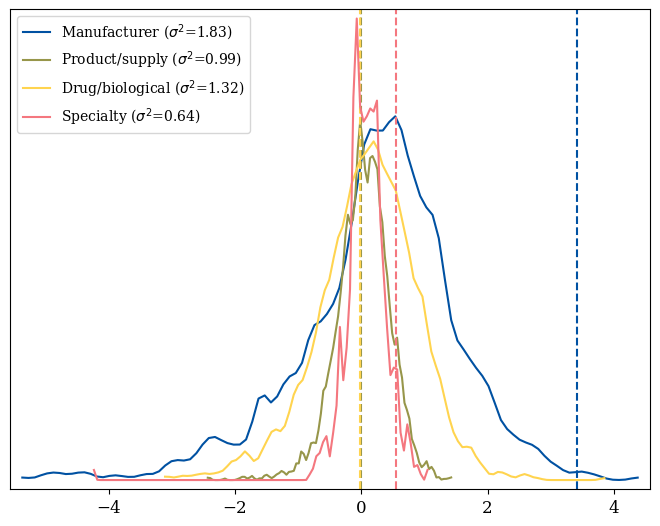

In [32]:
### Single plots to inspect
re_diffs = {}
random_effects = {}
# for dataset_name in dataset_names:
z_cols = [z_col_map[i] for i in z_col_dict[dataset_name]]

colors_ = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a']

random_effects[dataset_name] = {}
re_diffs[dataset_name] = {}
for num in range(folds):
    sample = pd.DataFrame(data_dict[f"Z_test_{num}"],columns=z_cols).iloc[2253]
    
    random_effects = {model: results[dataset_name][num]["other_info"][model]["random_effects"] for model in ["GMENN"]}
    learned_stds = {model: results[dataset_name][num]["other_info"][model]["_stddev_z"] for model in ["GMENN"]}
    if num!=0:
        continue
    for l in range(len(learned_stds["GMENN"])):
        for c in range(random_effects["GMENN"][l].shape[1]):

            re = -1*random_effects["GMENN"][l][:,c].numpy()
#             re = tf.math.sigmoid(re).numpy()
#             re = ((tf.math.sigmoid(np.abs(random_effects["GMENN"][l][:,c])).numpy()-0.5)*np.sign(random_effects["GMENN"][l][:,c])).round(2)
            edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
#             edges_menn = tf.math.sigmoid(edges_menn).numpy()
            kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
            probabilities_menn = kde_menn.evaluate(edges_menn)
            plt.plot(edges_menn,  probabilities_menn/probabilities_menn.std(),color=colors_[l])
            plt.axvline(tf.gather(-1*random_effects["GMENN"][l][:,c],sample[l]),color=colors_[l], linestyle="dashed", label='_nolegend_')
            
#     plt.title(f"Learned distribution for {dataset_name}, fold {num}, feature {z_cols[l]} ($\sigma$={learned_stds['GMENN'][l]})")
    legend = plt.legend([i+" ($\sigma^2$={:.2f})".format(round(learned_stds['GMENN'][num_i][0],2)) for num_i, i in enumerate(z_cols)],
                        loc="upper left", fontsize=10)#, ncol=1, handlelength=0.5,framealpha=0)
#     legend.get_frame().set_alpha(None) 
#     legend.get_frame().set_facecolor((0, 0,0, 0.0))
    plt.yticks([],[])            
        #     plt.legend([f"True ($\sigma^2$={dataset_name.split(',')[0]})", 
        #                 f"GMENN ($\sigma^2$={round(float(learned_stds['GMENN'].ravel()[0])**2,3)})", 
        #                 f"LMMNN ($\sigma^2$={round(float(learned_stds['LMMNN'][1][0])**2,3)})", 
        #                 f"ARMED ($\sigma^2$={round(float(learned_stds['ARMED (no adv.)'])**2,3)})"])
    
    ## From https://towardsdatascience.com/matplotlib-styles-for-scientific-plotting-d023f74515b4
    fsize = 15
    tsize = 18
    tdir = 'in'
    major = 5.0
    minor = 3.0
    lwidth = 0.8
    lhandle = 2.0

    plt.style.use('default')
    # plt.rcParams['text.usetex'] = True
    # plt.rcParams['font.size'] = fsize
    plt.rcParams['legend.fontsize'] = tsize
    plt.rcParams['xtick.direction'] = tdir
    plt.rcParams['ytick.direction'] = tdir
    plt.rcParams['xtick.major.size'] = major
    plt.rcParams['xtick.minor.size'] = minor
    plt.rcParams['ytick.major.size'] = 5.0
    plt.rcParams['ytick.minor.size'] = 3.0
    plt.rcParams['axes.linewidth'] = lwidth
    plt.rcParams['legend.handlelength'] = lhandle

    # plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0.02,0.02)
    # plt.gca().xaxis.set_major_locator(plt.NullLocator())
    # plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    
#     plt.savefig('interpret_example.svg', format='svg',bbox_inches='tight', pad_inches = 0)
#     plt.show()

### More datasets

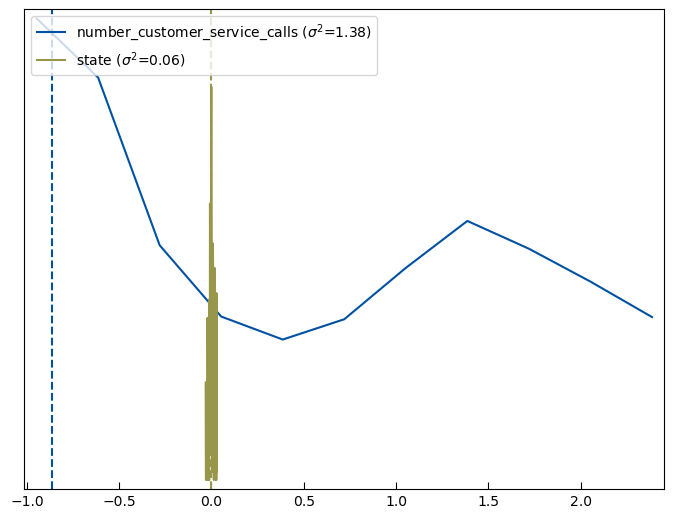

In [33]:
dataset_name = "churn"

data_path = f"{mode}_RS{RS}_hct{hct}"
if mode == "cv":
    data_path += f"_{folds}folds"
elif mode == "train_test":
    data_path += f"_split{1-test_ratio*100}-{test_ratio*100}"
elif mode == "train_val_test":
    data_path += f"_split{round(100-(test_ratio+val_ratio)*100)}-{round(test_ratio*100)}-{round(val_ratio*100)}"

# If no data_dict exists, run preprocessing, else load data_dict
if not os.path.exists(f"../data/prepared/{dataset_name}/"+data_path+"/data_dict.pickle"):
    dataset_preprocessing.process_dataset(dataset_name, target, mode, RS, hct, test_ratio, val_ratio, folds)
with open(f"../data/prepared/{dataset_name}/{data_path}/data_dict.pickle", 'rb') as handle:
    data_dict = pickle.load(handle)
z_cols = z_col_dict[dataset_name]
z_col_map = {col: col for col in z_cols}

### Single plots to inspect
re_diffs = {}
random_effects = {}
# for dataset_name in dataset_names:
z_cols = [z_col_map[i] for i in z_col_dict[dataset_name]]

colors_ = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a']

random_effects[dataset_name] = {}
re_diffs[dataset_name] = {}
for num in range(folds):
    sample = pd.DataFrame(data_dict[f"Z_test_{num}"],columns=z_cols).iloc[0]
    
    random_effects = {model: results[dataset_name][num]["other_info"][model]["random_effects"] for model in ["GMENN"]}
    learned_stds = {model: results[dataset_name][num]["other_info"][model]["_stddev_z"] for model in ["GMENN"]}
    if num!=0:
        continue
    for l in range(len(learned_stds["GMENN"])):
        for c in range(random_effects["GMENN"][l].shape[1]):

            re = -1*random_effects["GMENN"][l][:,c].numpy()
#             re = tf.math.sigmoid(re).numpy()
#             re = ((tf.math.sigmoid(np.abs(random_effects["GMENN"][l][:,c])).numpy()-0.5)*np.sign(random_effects["GMENN"][l][:,c])).round(2)
            edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
#             edges_menn = tf.math.sigmoid(edges_menn).numpy()
            kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
            probabilities_menn = kde_menn.evaluate(edges_menn)
            plt.plot(edges_menn,  probabilities_menn/probabilities_menn.std(),color=colors_[l])
            plt.axvline(tf.gather(-1*random_effects["GMENN"][l][:,c],sample[l]),color=colors_[l], linestyle="dashed", label='_nolegend_')
            
#     plt.title(f"Learned distribution for {dataset_name}, fold {num}, feature {z_cols[l]} ($\sigma$={learned_stds['GMENN'][l]})")
    legend = plt.legend([i+" ($\sigma^2$={:.2f})".format(round(learned_stds['GMENN'][num_i][0],2)) for num_i, i in enumerate(z_cols)],
                        loc="upper left", fontsize=10)#, ncol=1, handlelength=0.5,framealpha=0)
#     legend.get_frame().set_alpha(None) 
#     legend.get_frame().set_facecolor((0, 0,0, 0.0))
    plt.yticks([],[])            
        #     plt.legend([f"True ($\sigma^2$={dataset_name.split(',')[0]})", 
        #                 f"GMENN ($\sigma^2$={round(float(learned_stds['GMENN'].ravel()[0])**2,3)})", 
        #                 f"LMMNN ($\sigma^2$={round(float(learned_stds['LMMNN'][1][0])**2,3)})", 
        #                 f"ARMED ($\sigma^2$={round(float(learned_stds['ARMED (no adv.)'])**2,3)})"])
    
    ## From https://towardsdatascience.com/matplotlib-styles-for-scientific-plotting-d023f74515b4
    fsize = 15
    tsize = 18
    tdir = 'in'
    major = 5.0
    minor = 3.0
    lwidth = 0.8
    lhandle = 2.0

    plt.style.use('default')
    # plt.rcParams['text.usetex'] = True
    # plt.rcParams['font.size'] = fsize
    plt.rcParams['legend.fontsize'] = tsize
    plt.rcParams['xtick.direction'] = tdir
    plt.rcParams['ytick.direction'] = tdir
    plt.rcParams['xtick.major.size'] = major
    plt.rcParams['xtick.minor.size'] = minor
    plt.rcParams['ytick.major.size'] = 5.0
    plt.rcParams['ytick.minor.size'] = 3.0
    plt.rcParams['axes.linewidth'] = lwidth
    plt.rcParams['legend.handlelength'] = lhandle

    # plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0.02,0.02)
    # plt.gca().xaxis.set_major_locator(plt.NullLocator())
    # plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    
#     plt.savefig(f'learned_dist_{dataset_name}.svg', format='svg',bbox_inches='tight', pad_inches = 0)
#     plt.show()

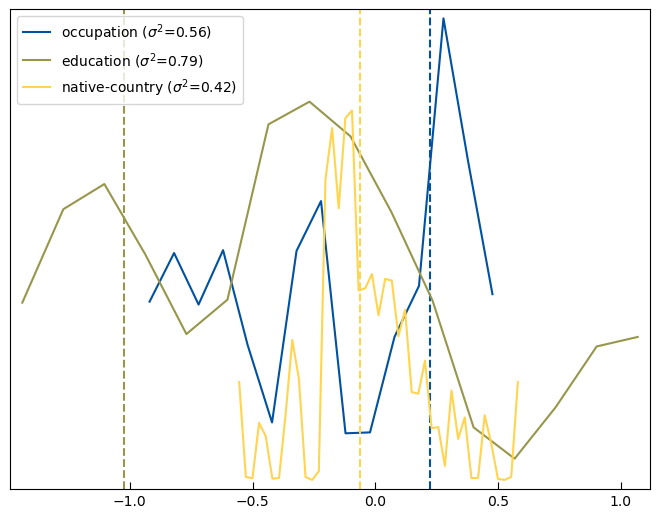

In [34]:
dataset_name = "adult"

data_path = f"{mode}_RS{RS}_hct{hct}"
if mode == "cv":
    data_path += f"_{folds}folds"
elif mode == "train_test":
    data_path += f"_split{1-test_ratio*100}-{test_ratio*100}"
elif mode == "train_val_test":
    data_path += f"_split{round(100-(test_ratio+val_ratio)*100)}-{round(test_ratio*100)}-{round(val_ratio*100)}"

# If no data_dict exists, run preprocessing, else load data_dict
if not os.path.exists(f"../data/prepared/{dataset_name}/"+data_path+"/data_dict.pickle"):
    dataset_preprocessing.process_dataset(dataset_name, target, mode, RS, hct, test_ratio, val_ratio, folds)
with open(f"../data/prepared/{dataset_name}/{data_path}/data_dict.pickle", 'rb') as handle:
    data_dict = pickle.load(handle)
z_cols = z_col_dict[dataset_name]
z_col_map = {col: col for col in z_cols}

### Single plots to inspect
re_diffs = {}
random_effects = {}
# for dataset_name in dataset_names:
z_cols = [z_col_map[i] for i in z_col_dict[dataset_name]]

colors_ = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a']

random_effects[dataset_name] = {}
re_diffs[dataset_name] = {}
for num in range(folds):
    sample = pd.DataFrame(data_dict[f"Z_test_{num}"],columns=z_cols).iloc[0]
    
    random_effects = {model: results[dataset_name][num]["other_info"][model]["random_effects"] for model in ["GMENN"]}
    learned_stds = {model: results[dataset_name][num]["other_info"][model]["_stddev_z"] for model in ["GMENN"]}
    if num!=0:
        continue
    for l in range(len(learned_stds["GMENN"])):
        for c in range(random_effects["GMENN"][l].shape[1]):

            re = -1*random_effects["GMENN"][l][:,c].numpy()
#             re = tf.math.sigmoid(re).numpy()
#             re = ((tf.math.sigmoid(np.abs(random_effects["GMENN"][l][:,c])).numpy()-0.5)*np.sign(random_effects["GMENN"][l][:,c])).round(2)
            edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
#             edges_menn = tf.math.sigmoid(edges_menn).numpy()
            kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
            probabilities_menn = kde_menn.evaluate(edges_menn)
            plt.plot(edges_menn,  probabilities_menn/probabilities_menn.std(),color=colors_[l])
            plt.axvline(tf.gather(-1*random_effects["GMENN"][l][:,c],sample[l]),color=colors_[l], linestyle="dashed", label='_nolegend_')
            
#     plt.title(f"Learned distribution for {dataset_name}, fold {num}, feature {z_cols[l]} ($\sigma$={learned_stds['GMENN'][l]})")
    legend = plt.legend([i+" ($\sigma^2$={:.2f})".format(round(learned_stds['GMENN'][num_i][0],2)) for num_i, i in enumerate(z_cols)],
                        loc="upper left", fontsize=10)#, ncol=1, handlelength=0.5,framealpha=0)
#     legend.get_frame().set_alpha(None) 
#     legend.get_frame().set_facecolor((0, 0,0, 0.0))
    plt.yticks([],[])            
        #     plt.legend([f"True ($\sigma^2$={dataset_name.split(',')[0]})", 
        #                 f"GMENN ($\sigma^2$={round(float(learned_stds['GMENN'].ravel()[0])**2,3)})", 
        #                 f"LMMNN ($\sigma^2$={round(float(learned_stds['LMMNN'][1][0])**2,3)})", 
        #                 f"ARMED ($\sigma^2$={round(float(learned_stds['ARMED (no adv.)'])**2,3)})"])
    
    ## From https://towardsdatascience.com/matplotlib-styles-for-scientific-plotting-d023f74515b4
    fsize = 15
    tsize = 18
    tdir = 'in'
    major = 5.0
    minor = 3.0
    lwidth = 0.8
    lhandle = 2.0

    plt.style.use('default')
    # plt.rcParams['text.usetex'] = True
    # plt.rcParams['font.size'] = fsize
    plt.rcParams['legend.fontsize'] = tsize
    plt.rcParams['xtick.direction'] = tdir
    plt.rcParams['ytick.direction'] = tdir
    plt.rcParams['xtick.major.size'] = major
    plt.rcParams['xtick.minor.size'] = minor
    plt.rcParams['ytick.major.size'] = 5.0
    plt.rcParams['ytick.minor.size'] = 3.0
    plt.rcParams['axes.linewidth'] = lwidth
    plt.rcParams['legend.handlelength'] = lhandle

    # plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0.02,0.02)
    # plt.gca().xaxis.set_major_locator(plt.NullLocator())
    # plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    
#     plt.savefig(f'learned_dist_{dataset_name}.svg', format='svg',bbox_inches='tight', pad_inches = 0)
#     plt.show()

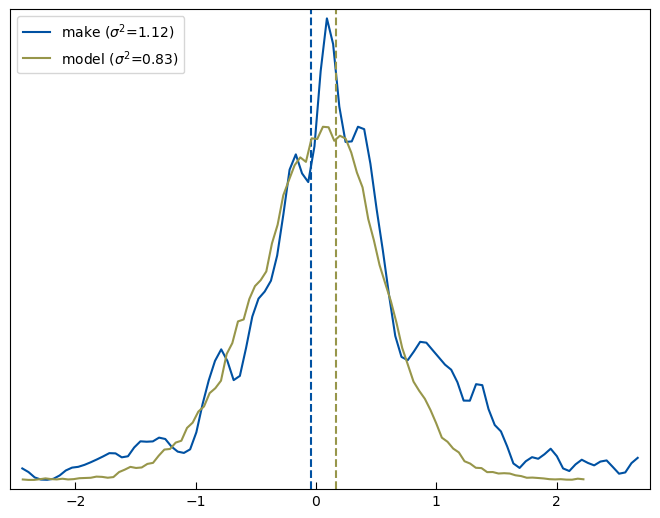

In [35]:
dataset_name = "road-safety-drivers-sex"

data_path = f"{mode}_RS{RS}_hct{hct}"
if mode == "cv":
    data_path += f"_{folds}folds"
elif mode == "train_test":
    data_path += f"_split{1-test_ratio*100}-{test_ratio*100}"
elif mode == "train_val_test":
    data_path += f"_split{round(100-(test_ratio+val_ratio)*100)}-{round(test_ratio*100)}-{round(val_ratio*100)}"

# If no data_dict exists, run preprocessing, else load data_dict
if not os.path.exists(f"../data/prepared/{dataset_name}/"+data_path+"/data_dict.pickle"):
    dataset_preprocessing.process_dataset(dataset_name, target, mode, RS, hct, test_ratio, val_ratio, folds)
with open(f"../data/prepared/{dataset_name}/{data_path}/data_dict.pickle", 'rb') as handle:
    data_dict = pickle.load(handle)
z_cols = z_col_dict[dataset_name]
z_col_map = {col: col for col in z_cols}

### Single plots to inspect
re_diffs = {}
random_effects = {}
# for dataset_name in dataset_names:
z_cols = [z_col_map[i] for i in z_col_dict[dataset_name]]

colors_ = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a']

random_effects[dataset_name] = {}
re_diffs[dataset_name] = {}
for num in range(folds):
    sample = pd.DataFrame(data_dict[f"Z_test_{num}"],columns=z_cols).iloc[0]
    
    random_effects = {model: results[dataset_name][num]["other_info"][model]["random_effects"] for model in ["GMENN"]}
    learned_stds = {model: results[dataset_name][num]["other_info"][model]["_stddev_z"] for model in ["GMENN"]}
    if num!=0:
        continue
    for l in range(len(learned_stds["GMENN"])):
        for c in range(random_effects["GMENN"][l].shape[1]):

            re = -1*random_effects["GMENN"][l][:,c].numpy()
#             re = tf.math.sigmoid(re).numpy()
#             re = ((tf.math.sigmoid(np.abs(random_effects["GMENN"][l][:,c])).numpy()-0.5)*np.sign(random_effects["GMENN"][l][:,c])).round(2)
            edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
#             edges_menn = tf.math.sigmoid(edges_menn).numpy()
            kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
            probabilities_menn = kde_menn.evaluate(edges_menn)
            plt.plot(edges_menn,  probabilities_menn/probabilities_menn.std(),color=colors_[l])
            plt.axvline(tf.gather(-1*random_effects["GMENN"][l][:,c],sample[l]),color=colors_[l], linestyle="dashed", label='_nolegend_')
            
#     plt.title(f"Learned distribution for {dataset_name}, fold {num}, feature {z_cols[l]} ($\sigma$={learned_stds['GMENN'][l]})")
    legend = plt.legend([i+" ($\sigma^2$={:.2f})".format(round(learned_stds['GMENN'][num_i][0],2)) for num_i, i in enumerate(z_cols)],
                        loc="upper left", fontsize=10)#, ncol=1, handlelength=0.5,framealpha=0)
#     legend.get_frame().set_alpha(None) 
#     legend.get_frame().set_facecolor((0, 0,0, 0.0))
    plt.yticks([],[])            
        #     plt.legend([f"True ($\sigma^2$={dataset_name.split(',')[0]})", 
        #                 f"GMENN ($\sigma^2$={round(float(learned_stds['GMENN'].ravel()[0])**2,3)})", 
        #                 f"LMMNN ($\sigma^2$={round(float(learned_stds['LMMNN'][1][0])**2,3)})", 
        #                 f"ARMED ($\sigma^2$={round(float(learned_stds['ARMED (no adv.)'])**2,3)})"])
    
    ## From https://towardsdatascience.com/matplotlib-styles-for-scientific-plotting-d023f74515b4
    fsize = 15
    tsize = 18
    tdir = 'in'
    major = 5.0
    minor = 3.0
    lwidth = 0.8
    lhandle = 2.0

    plt.style.use('default')
    # plt.rcParams['text.usetex'] = True
    # plt.rcParams['font.size'] = fsize
    plt.rcParams['legend.fontsize'] = tsize
    plt.rcParams['xtick.direction'] = tdir
    plt.rcParams['ytick.direction'] = tdir
    plt.rcParams['xtick.major.size'] = major
    plt.rcParams['xtick.minor.size'] = minor
    plt.rcParams['ytick.major.size'] = 5.0
    plt.rcParams['ytick.minor.size'] = 3.0
    plt.rcParams['axes.linewidth'] = lwidth
    plt.rcParams['legend.handlelength'] = lhandle

    # plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0.02,0.02)
    # plt.gca().xaxis.set_major_locator(plt.NullLocator())
    # plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    
#     plt.savefig(f'learned_dist_{dataset_name}.svg', format='svg',bbox_inches='tight', pad_inches = 0)
#     plt.show()